In [116]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sn

In [133]:
PATCH_SIZE = (256, 256)
NUM_CLASSES = 16
BATCH_SIZE = 32
EPOCHS = 10

In [134]:
# Function to read and preprocess an image
def read_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMAGE_SIZE)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Function to read and preprocess a mask
def read_and_preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMAGE_SIZE)
    mask = tf.keras.utils.to_categorical(mask, NUM_CLASSES)
    return mask

def load_data(image_folder, mask_folder):
    image_paths = sorted(os.listdir(image_folder))
    mask_paths = sorted(os.listdir(mask_folder))
    
    images = []
    masks = []
    
    for image_path, mask_path in zip(image_paths, mask_paths):
        image = read_and_preprocess_image(os.path.join(image_folder, image_path))
        mask = read_and_preprocess_mask(os.path.join(mask_folder, mask_path))
        
        # Patchify the image and mask
        for i in range(0, image.shape[0] - PATCH_SIZE[0] + 1, PATCH_SIZE[0]):
            for j in range(0, image.shape[1] - PATCH_SIZE[1] + 1, PATCH_SIZE[1]):
                patch_image = image[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1], :]
                patch_mask = mask[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1], :]
                images.append(patch_image)
                masks.append(patch_mask)
    
    return np.array(images), np.array(masks)

In [135]:
# Define labels
labels = ['background','industrial land','urban residential','rural residential',
          'traffic land','paddy field','irrigated land', 'dry cropland',
          'garden plot','arbor woodland','shrub land','natural grassland',
          'artificial grassland','river', 'lake','pond']

def show_mask_with_label(batch, labels, _min, _max, alpha=1):
    values, counts = np.unique(batch, return_counts=True)
    counts = counts / (256*256)
    im = plt.imshow(batch, cmap='viridis', vmin = _min, vmax = _max, alpha=alpha)
    colors = [im.cmap(im.norm(value)) for value in values]
    
    patches = [mpatches.Patch(color=colors[i], label=labels[values[i]]) \
               for i in range(len(values)) if counts[i] > 0.005]
    plt.legend(handles=patches)

In [136]:
train_images, train_masks = load_data('C:/Users/soumi/OneDrive/Desktop/SIH/dataset/terain_images/', 'C:/Users/soumi/OneDrive/Desktop/SIH/dataset/masks_images/')

# Load validation data
val_images, val_masks = load_data('C:/Users/soumi/OneDrive/Desktop/SIH/dataset/val_images/', 'C:/Users/soumi/OneDrive/Desktop/SIH/dataset/val_masks/')

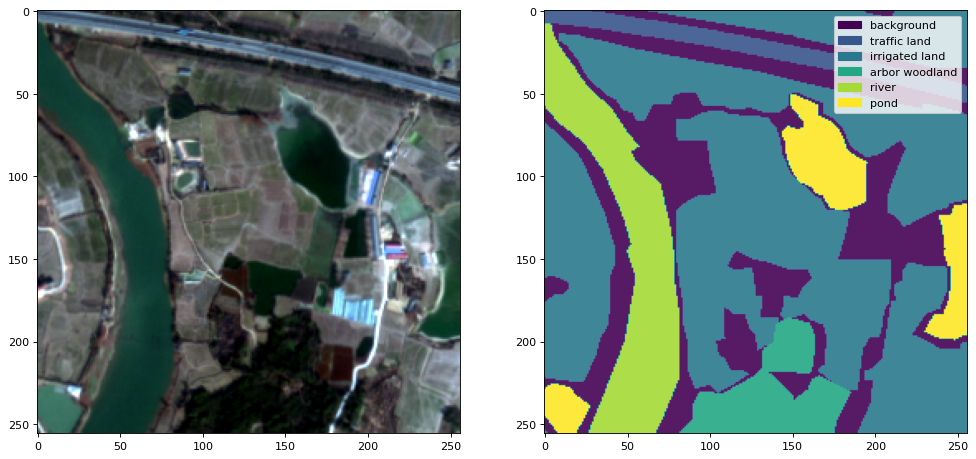

In [137]:
train_img_dir = "C:/Users/soumi/OneDrive/Desktop/SIH/dataset/terain_images/"
train_mask_dir = "C:/Users/soumi/OneDrive/Desktop/SIH/dataset/masks_images/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

img_list.sort()
msk_list.sort()

num_images = len(img_list)

if num_images == 0:
    print("No images found in the specified directories.")
else:
    img_num = random.randint(0, num_images - 1)

    img_path = os.path.join(train_img_dir, img_list[img_num])
    mask_path = os.path.join(train_mask_dir, msk_list[img_num])

    img_for_plot = cv2.imread(img_path, 1)
    mask_for_plot = cv2.imread(mask_path, 0)

    if img_for_plot is None:
        print(f"Failed to load image: {img_path}")
    elif mask_for_plot is None:
        print(f"Failed to load mask: {mask_path}")
    else:
        img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

        _min, _max = np.amin(mask_for_plot), np.amax(mask_for_plot)

        plt.figure(figsize=(15, 15), dpi=80)

        plt.subplot(1, 2, 1)
        plt.imshow(img_for_plot.astype('uint8'))

        plt.subplot(1, 2, 2)
        show_mask_with_label(mask_for_plot, labels, _min, _max, alpha=0.9) # add some opacity

        plt.show()

In [138]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [139]:
# Define the IoU loss function
def iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15)
    return 1 - iou

In [140]:
def unet_model(input_shape):
    inputs = Input(input_shape)
    
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)
    
    outputs = Conv2D(16, (1,1), activation = 'sigmoid')(c9)
    
    model = Model(inputs, outputs)
    return model

In [141]:
model = unet_model(input_shape=(PATCH_SIZE[0], PATCH_SIZE[1], 3))
model.compile(optimizer='adam', loss=iou_loss, metrics=['accuracy'])

In [142]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [143]:
with tf.device('/GPU:0'):
    history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 0.9411 - accuracy: 0.0874 - val_loss: 0.9364 - val_accuracy: 0.1676
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.9359 - accuracy: 0.1184 - val_loss: 0.9227 - val_accuracy: 0.1636
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.9174 - accuracy: 0.1351 - val_loss: 0.8918 - val_accuracy: 0.1824
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.9031 - accuracy: 0.2286 - val_loss: 0.8779 - val_accuracy: 0.2418
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.8927 - accuracy: 0.2715 - val_loss: 0.8706 - val_accuracy: 0.2508
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.8836 - accuracy: 0.2801 - val_loss: 0.8626 - val_accuracy: 0.2508
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.8760 - accuracy: 0.2839 - val_loss: 0.8553 - val_accuracy: 0.2508
Epoch 8/10
1/1 [=======================

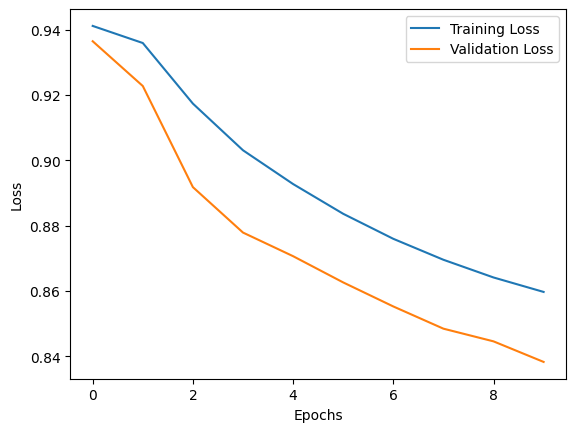

In [144]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 1s 575ms/step


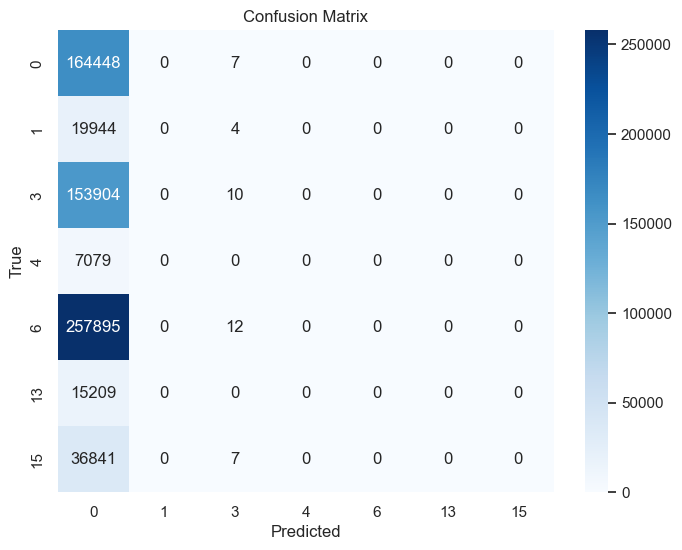

In [151]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


# Predict masks using the trained model
predicted_masks = model.predict(val_images)

# Convert predicted masks and true masks to binary masks
predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)
true_masks_binary = (val_masks > 0.5).astype(np.uint8)

# Flatten the masks for confusion matrix calculation
predicted_masks_flat = predicted_masks_binary.reshape(-1, NUM_CLASSES)
true_masks_flat = true_masks_binary.reshape(-1, NUM_CLASSES)

# Encode class labels
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(np.argmax(true_masks_flat, axis=1))
predicted_labels = label_encoder.transform(np.argmax(predicted_masks_flat, axis=1))

# Calculate confusion matrix
confusion_matrix_data = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix heatmap using Seaborn
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 556ms/step


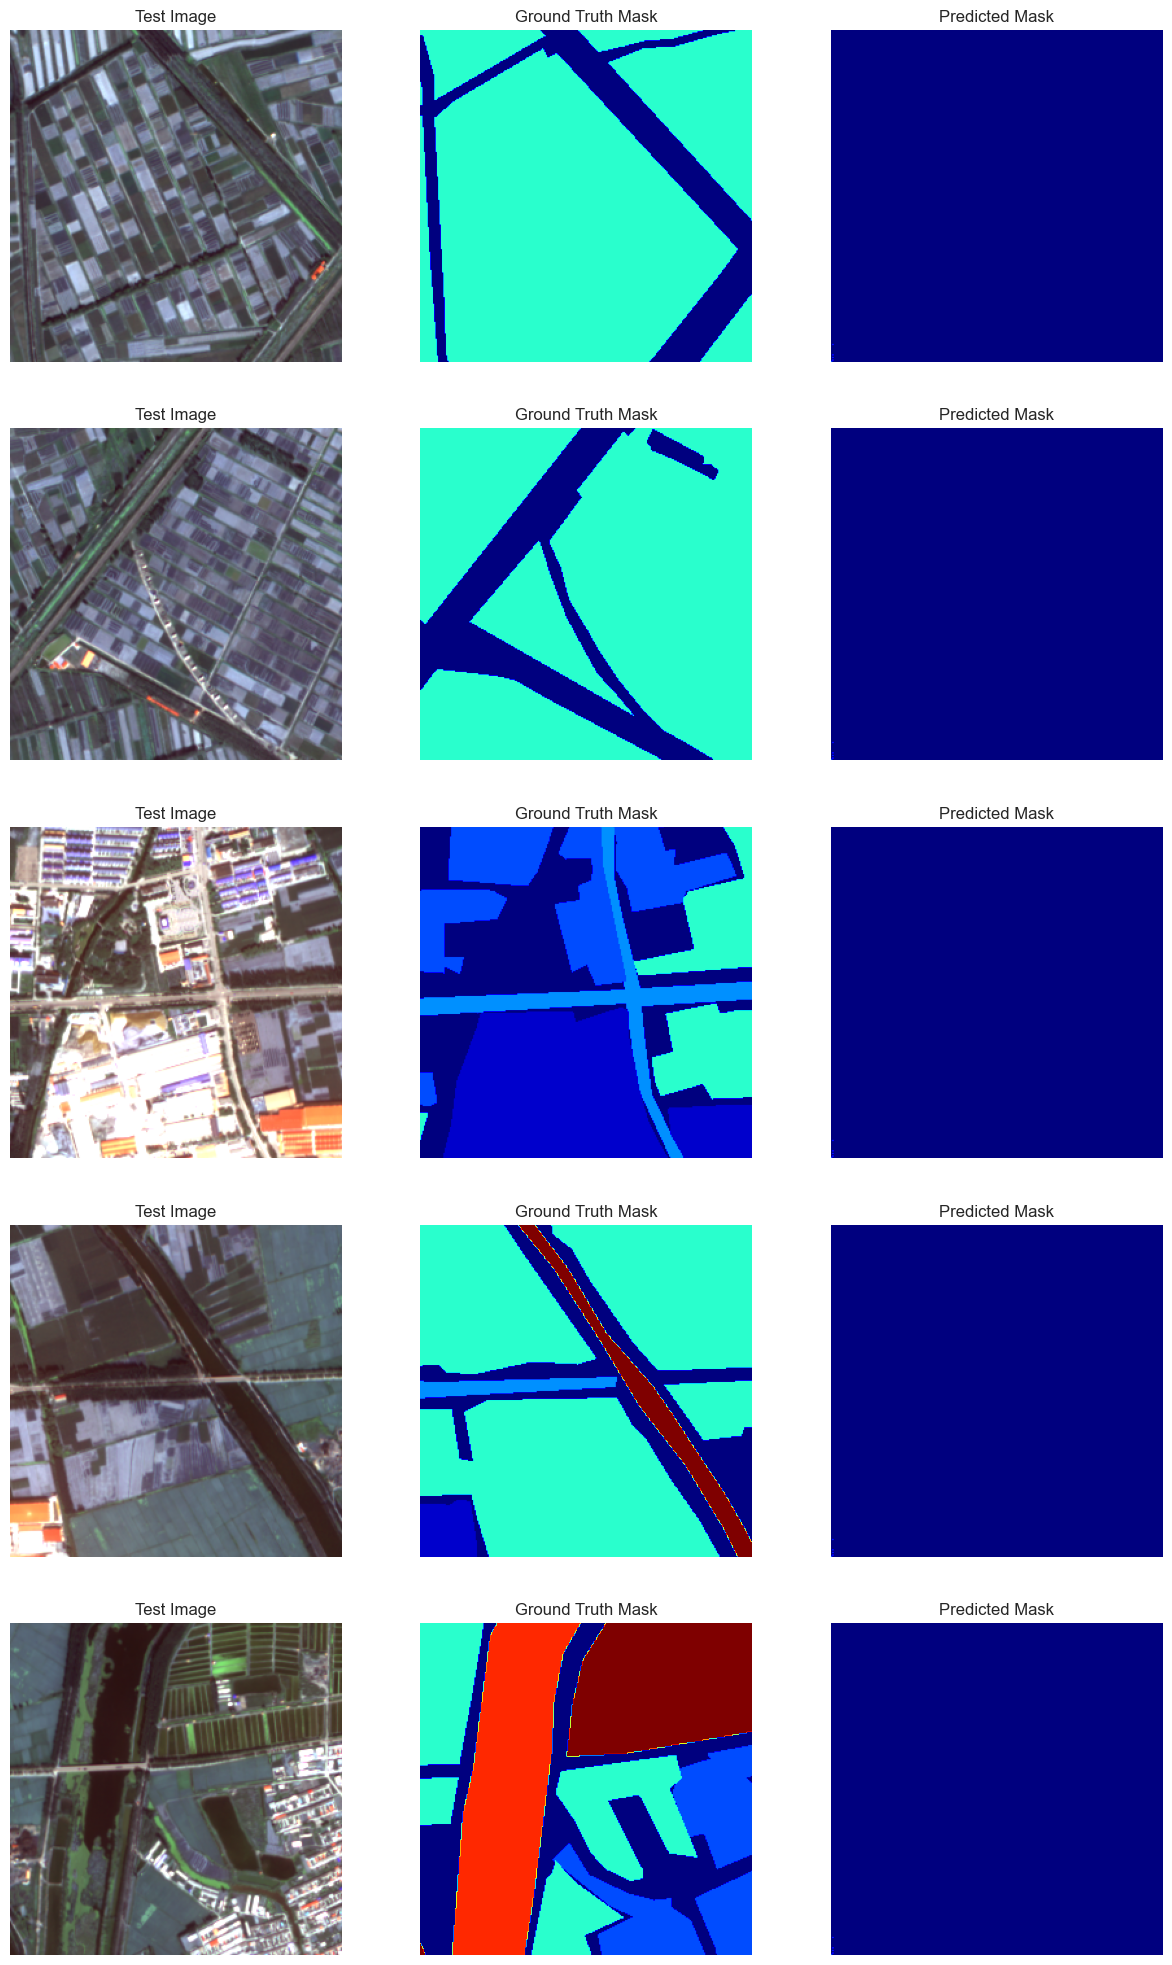

In [152]:
predicted_masks = model.predict(val_images)

# Function to display images and masks
def display_images_and_masks(images, masks, predicted_masks=None, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title('Test Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(np.argmax(masks[i], axis=-1), cmap='jet', vmin=0, vmax=NUM_CLASSES - 1)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        if predicted_masks is not None:
            plt.subplot(num_samples, 3, i * 3 + 3)
            plt.imshow(np.argmax(predicted_masks[i], axis=-1), cmap='jet', vmin=0, vmax=NUM_CLASSES - 1)
            plt.title('Predicted Mask')
            plt.axis('off')

# Display a few test images and their masks
num_samples_to_display = 5
display_images_and_masks(val_images[:num_samples_to_display], val_masks[:num_samples_to_display], predicted_masks[:num_samples_to_display])

# Show the plots
plt.show()